<a href="https://colab.research.google.com/github/GiorgosMaragkopoulos/Quantum-data-encoding-using-QAE-PQAE/blob/main/Wines_Batches_Angle_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batched Quantum Autoencoders (QAEs) for latent space encoding of the wine dataset vs linear autoencoders

In this notebook we are going to implement a batched Quantum Autoencoder (QAE) for reconstructing the wines dataset and we are going to compare it to linear autoencoders. QAEs embed a quantum feature map in the bottleneck of an autoencoder, in order to achieve greater representation power. A batched QAE uses multiple such feature maps, which cover the bottleneck in parts.

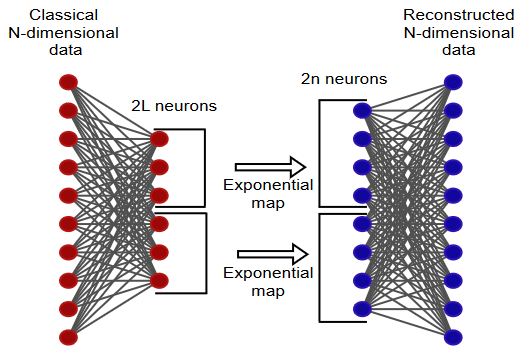

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,MinMaxScaler , Normalizer
from torch.nn.functional import normalize


# Load Iris dataset
wine = datasets.load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)

Here we are using a linear autoencoder which reduces the dimensionality to 12, before decoding it back to 13. In order to follow the exact same logic as the QAE, the decoder will actually use a layer to increase the dimensions from 12 to 16 and then another layer from 16 to the original space (13).

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(13, 12)  # 4 inputs to 3 nodes (bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 16),  # 3 nodes to 4 outputs
            nn.Linear(16, 13)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
# Instantiate the model, define loss function and optimizer
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, X)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [500/10000], Loss: 0.0125
Epoch [1000/10000], Loss: 0.0085
Epoch [1500/10000], Loss: 0.0082
Epoch [2000/10000], Loss: 0.0082
Epoch [2500/10000], Loss: 0.0081
Epoch [3000/10000], Loss: 0.0080
Epoch [3500/10000], Loss: 0.0081
Epoch [4000/10000], Loss: 0.0082
Epoch [4500/10000], Loss: 0.0082
Epoch [5000/10000], Loss: 0.0080
Epoch [5500/10000], Loss: 0.0080
Epoch [6000/10000], Loss: 0.0080
Epoch [6500/10000], Loss: 0.0080
Epoch [7000/10000], Loss: 0.0080
Epoch [7500/10000], Loss: 0.0080
Epoch [8000/10000], Loss: 0.0081
Epoch [8500/10000], Loss: 0.0081
Epoch [9000/10000], Loss: 0.0081
Epoch [9500/10000], Loss: 0.0080
Epoch [10000/10000], Loss: 0.0080


# Batched Polynmial feature map

In [4]:
class Custom_Autoencoder(nn.Module):
    def __init__(self):
        super(Custom_Autoencoder, self).__init__()

        self.encoder = nn.Linear(13, 12)  # Reduce dimensionality to 12
        self.decoder = nn.Linear(16, 13)  # Decode back to original dimensionality

    def forward(self, x):
        x = self.encoder(x)

        # Initialize list to collect new feature maps
        feature_maps = []

        # Apply the polynomial feature map to each triplet of neurons
        for i in range(0, 12, 3):
            x_triplet = x[:, i:i+3]  # Extract triplet

            x1_cube = x_triplet[:, 0:1] ** 3
            x2_cube = x_triplet[:, 1:2] ** 3
            x3_cube = x_triplet[:, 2:3] ** 3

            x1_x2_x3 = x_triplet[:, 0:1] * x_triplet[:, 1:2] * x_triplet[:, 2:3]

            # Combine the polynomial features and append to the feature maps list
            poly_features = torch.cat((x1_cube, x2_cube, x3_cube, x1_x2_x3), dim=-1)
            feature_maps.append(poly_features)

        # Concatenate all the new features together to form a 16-dimensional vector
        new_features = torch.cat(feature_maps, dim=-1)

        # Decode the new features back to the original dimensionality
        x = self.decoder(new_features)

        return x


qae = Custom_Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(qae.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = qae(X)
    loss = criterion(outputs, X)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [500/10000], Loss: 0.1130
Epoch [1000/10000], Loss: 0.0897
Epoch [1500/10000], Loss: 0.0748
Epoch [2000/10000], Loss: 0.0700
Epoch [2500/10000], Loss: 0.0670
Epoch [3000/10000], Loss: 0.0651
Epoch [3500/10000], Loss: 0.0637
Epoch [4000/10000], Loss: 0.0654
Epoch [4500/10000], Loss: 0.0618
Epoch [5000/10000], Loss: 0.0605
Epoch [5500/10000], Loss: 0.0615
Epoch [6000/10000], Loss: 0.0595
Epoch [6500/10000], Loss: 0.0585
Epoch [7000/10000], Loss: 0.0578
Epoch [7500/10000], Loss: 0.0582
Epoch [8000/10000], Loss: 0.0567
Epoch [8500/10000], Loss: 0.0563
Epoch [9000/10000], Loss: 0.0553
Epoch [9500/10000], Loss: 0.0545
Epoch [10000/10000], Loss: 0.0531


The QAE class uses the exponential map using the pauli matrices for each triads of the bottleneck.


In [5]:
class Quantum_Autoencoder(nn.Module):
    def __init__(self):
        super(Quantum_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(13, 12)  # 4 inputs to 3 nodes (bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 13)  # 3 nodes to 4 outputs
        )


        self.pauli_matrices = torch.zeros(3,1, 2, 2, dtype=torch.cfloat)


        self.q0 = torch.tensor([[1], [0]], dtype=torch.cfloat)
        self.q1 = torch.tensor([[0], [1]], dtype=torch.cfloat)

        # Define the Pauli matrices
        self.sigma1 = torch.tensor([[1, 0], [0, 1]], dtype=torch.complex64)
        self.sigma2 = torch.tensor([[0, 1], [1, 0]], dtype=torch.complex64)
        self.sigma3 = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex64)
        self.sigma4 = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex64)

        self.pauli_matrices[0,:,:,:] = self.sigma2
        self.pauli_matrices[1,:,:,:] = self.sigma3
        self.pauli_matrices[2,:,:,:] = self.sigma4





    def forward(self, x):
        x = self.encoder(x)

        input_expanded = x.view(178, 12, 1, 1)

        result_tensors = []

        for i in range(4):
          input_batch = input_expanded[:,(i*3):(i*3+3),:,:]
          matrix_expanded = self.pauli_matrices.view(1, 3, 1, 2, 2)
          result_matrix = torch.sum(input_batch.view(178, 3, 1, 1, 1) * matrix_expanded, dim=1).squeeze(1)

          exp_matrix = torch.matrix_exp(1j*result_matrix)
          Final_state = torch.matmul(exp_matrix,self.q0).squeeze(dim=2)
          Real_Imag = torch.cat((Final_state.real, Final_state.imag), dim=1)

          result_tensors.append(Real_Imag)

        concatenated_result = torch.cat(result_tensors, dim=1)

        x = self.decoder(concatenated_result)

        return x




In [6]:

# Instantiate the model, define loss function and optimizer
qae = Quantum_Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(qae.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = qae(X)
    loss = criterion(outputs, X)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [500/10000], Loss: 0.0715
Epoch [1000/10000], Loss: 0.0148
Epoch [1500/10000], Loss: 0.0091
Epoch [2000/10000], Loss: 0.0075
Epoch [2500/10000], Loss: 0.0069
Epoch [3000/10000], Loss: 0.0059
Epoch [3500/10000], Loss: 0.0054
Epoch [4000/10000], Loss: 0.0050
Epoch [4500/10000], Loss: 0.0049
Epoch [5000/10000], Loss: 0.0044
Epoch [5500/10000], Loss: 0.0045
Epoch [6000/10000], Loss: 0.0044
Epoch [6500/10000], Loss: 0.0042
Epoch [7000/10000], Loss: 0.0040
Epoch [7500/10000], Loss: 0.0040
Epoch [8000/10000], Loss: 0.0039
Epoch [8500/10000], Loss: 0.0038
Epoch [9000/10000], Loss: 0.0041
Epoch [9500/10000], Loss: 0.0038
Epoch [10000/10000], Loss: 0.0036
